# Decision Trees and Random Forests

# This is a partially complete code notebook. Go through the following sections and at the end , write down code for following questions:
##Q1. Create a decision tree classification model that can predict digits correctly
##Q2. Calculate the precision , recall , f1-score , support metrics for decision tree model 
##Q3. Explain the above calculated metrics 
##Q4. Change the depth of decision trees based model and see how the accuracy metrics change w.r.t depth
##Q5. Create a Random Forest based digits classifier that can predict the digits correctly
##Q6. Calculate the precision , recall , f1-score , support metrics for Random Forest model 


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

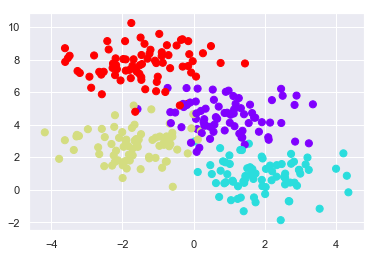

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)
(06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

D:\Applications\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


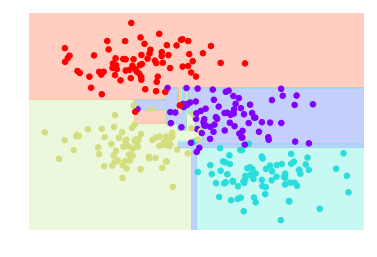

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

### Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)


It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

D:\Applications\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Applications\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


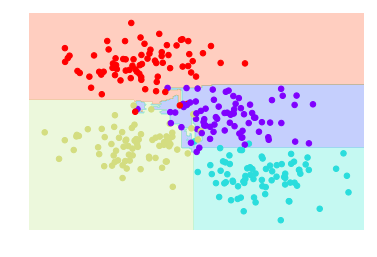

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

D:\Applications\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


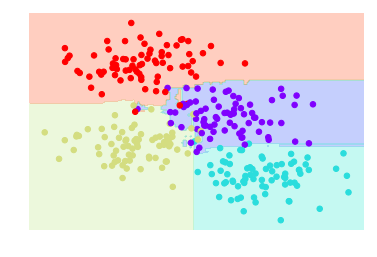

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

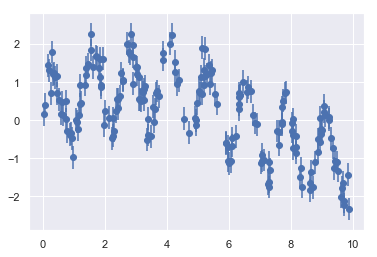

In [9]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

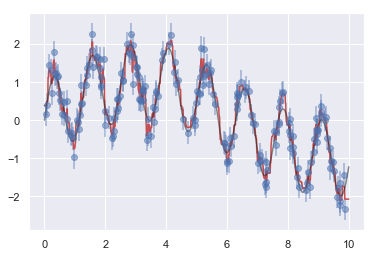

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

[1 2 3 4 5 6 7]


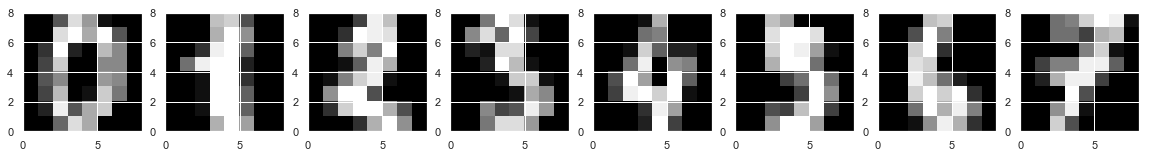

In [34]:
# plot the digits: each image is originally 8x8 pixels but is encoded as a vector in the data so that we need to reshape it
import matplotlib.pyplot as plt

# Also display class
print(digits.target[1:8])
figure, axes = plt.subplots(1, 8, figsize=(20,20))
for i in range(0, 8):
    axes[i].imshow(np.reshape(digits.data[i], (8, 8)), cmap='gray', aspect='equal', extent=[0, 8, 0, 8], interpolation='nearest')

In [46]:
from sklearn.model_selection import train_test_split 

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# We will compare basic decision tree and random forest
tree_model = DecisionTreeClassifier()
forest_model = RandomForestClassifier(n_estimators=100, random_state=0)

tree_model.fit(X_train, y_train)
forest_model.fit(X_train, y_train)

tree_y_pred = tree_model.predict(X_test)
forest_y_pred = forest_model.predict(X_test)

We can take a look at the classification report for this classifier:

In [48]:
from sklearn.metrics import classification_report 

print('Decision Tree')
print(classification_report(y_test, tree_y_pred))
print('Random Forest')
print(classification_report(y_test, forest_y_pred))

Decision Tree
             precision    recall  f1-score   support

          0       0.95      0.95      0.95        60
          1       0.78      0.78      0.78        55
          2       0.86      0.83      0.84        46
          3       0.77      0.83      0.80        58
          4       0.80      0.76      0.78        49
          5       0.94      0.86      0.90        51
          6       0.90      0.95      0.92        57
          7       0.86      0.92      0.89        60
          8       0.72      0.68      0.70        53
          9       0.73      0.75      0.74        51

avg / total       0.83      0.83      0.83       540

Random Forest
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        60
          1       0.92      0.98      0.95        55
          2       1.00      0.98      0.99        46
          3       0.98      0.93      0.96        58
          4       1.00      0.98      0.99        49
          5   

We can see that basic decision tree can be very accurate on a couple of digits but not so good on others. Meaning that it will correctly predict eg 95% of zeros but only 72% of heights. On the contrary, random forest precision is pretty similar and > 90% on all digits. 

Precision is the percentage of true positives, maximizing it will minimize false positives.
Recall is the percentage of correctly classified digits in the dataset, maximing it will minimize the chance of missing positive cases.
F1-score combines both to take into account imbalanced values as it requires both precision and recall to have a reasonable value to be higher.

And for good measure, we plot the confusion matrix:

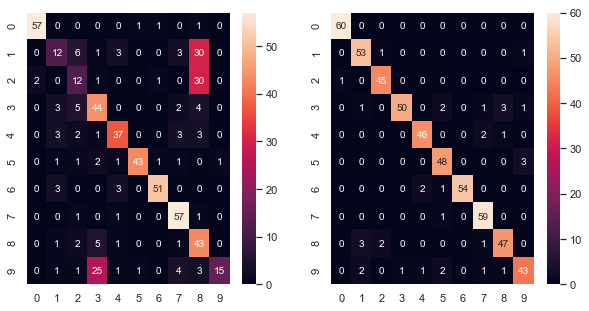

In [57]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

tree_matrix = pd.DataFrame(confusion_matrix(y_test, tree_y_pred))
forest_matrix = pd.DataFrame(confusion_matrix(y_test, forest_y_pred))

figure, axes = plt.subplots(1, 2, figsize=(10,5))
sn.heatmap(tree_matrix, annot=True, ax=axes[0])
sn.heatmap(forest_matrix, annot=True, ax=axes[1])

We find that a simple, untuned random forest results in a very accurate classification of the digits data.
We can however play with some of the hyperparameters in order to see the impact. For instance if we reduce the depth of the tree too much we guess that the classification will be worse. Random forest will probably be less affected due to the fact it is an ensemble model.

Decision Tree
             precision    recall  f1-score   support

          0       0.98      0.95      0.97        60
          1       0.50      0.22      0.30        55
          2       0.40      0.26      0.32        46
          3       0.56      0.76      0.65        58
          4       0.74      0.76      0.75        49
          5       0.93      0.84      0.89        51
          6       1.00      0.89      0.94        57
          7       0.79      0.95      0.86        60
          8       0.37      0.81      0.51        53
          9       0.94      0.29      0.45        51

avg / total       0.73      0.69      0.67       540

Random Forest
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        60
          1       0.90      0.96      0.93        55
          2       0.94      0.98      0.96        46
          3       0.98      0.86      0.92        58
          4       0.94      0.94      0.94        49
          5   

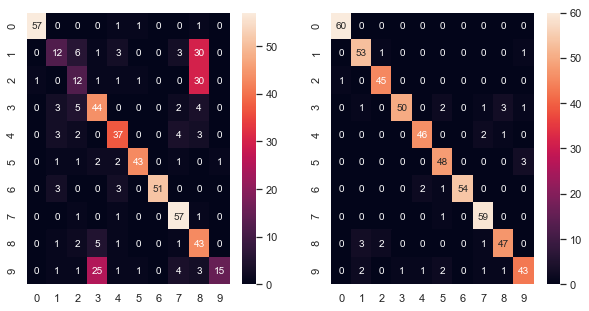

In [59]:
tree_model = DecisionTreeClassifier(max_depth=5)
forest_model = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)

tree_model.fit(X_train, y_train)
forest_model.fit(X_train, y_train)

tree_y_pred = tree_model.predict(X_test)
forest_y_pred = forest_model.predict(X_test)

print('Decision Tree')
print(classification_report(y_test, tree_y_pred))
print('Random Forest')
print(classification_report(y_test, forest_y_pred))

tree_matrix = pd.DataFrame(confusion_matrix(y_test, tree_y_pred))
forest_matrix = pd.DataFrame(confusion_matrix(y_test, forest_y_pred))

figure, axes = plt.subplots(1, 2, figsize=(10,5))
sn.heatmap(tree_matrix, annot=True, ax=axes[0])
sn.heatmap(forest_matrix, annot=True, ax=axes[1])

We clearly see that the basic decision tree is specifically affected by reducing depth too much in the matrix, a lot of ones and twos are for instance classified as heights.

## Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.